# wet bulb globe exposure analysis WBGT33 - fixed magnitude thresholds

Look at nAHD, PR and deltaI for different age groups: key global results and plots

rosa.pietroiusti@vub.be

Created April 8th 2024




In [1]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), cartopy, openpyxl, (statsmodels?)

import numpy as np
import pandas as pd
import os, glob, re 
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import dask
import matplotlib.pyplot as plt
import netCDF4

%matplotlib inline

#plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# import my variables settings functions from other scripts
from settings import *

# import fxns 
from functions import *
from utils import *
from plotscript import *

# import other packages/modules 

sys.path.append('../population/') # make this a module i can pip install and import ! 
from population_demographics_climate import * # move / rename this when good ! --> change to import demographics4climate as d4c


/apps/brussel/RL8/skylake/software/Python/3.10.4-GCCcore-11.3.0/lib/python3.10/site-packages/paramiko/transport.py:236: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
/apps/brussel/RL8/skylake/software/statsmodels/0.13.1-foss-2022a/lib/python3.10/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
from dask.distributed import Client 
client = Client()
client

/apps/brussel/RL8/skylake/software/dask/2022.10.0-foss-2022a/lib/python3.10/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39661 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:39661/status,
Dashboard: http://127.0.0.1:39661/status,Workers: 1
Total threads: 1,Total memory: 40.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35459,Workers: 1
Dashboard: http://127.0.0.1:39661/status,Total threads: 1
Started: Just now,Total memory: 40.00 GiB
Comm: tcp://127.0.0.1:44981,Total threads: 1
Dashboard: http://127.0.0.1:40617/status,Memory: 40.00 GiB
Nanny: tcp://127.0.0.1:36367,


In [3]:
start_message() # change indir to indir obs and datasets to datasets obs in start message

flags: {'models': 'ISIMIP3a', 'experiment': 'obsclim', 'metric': 'WBGT', 'method': 'shift_fit', 'time_method': None, 'shift_sigma': True, 'shift_period': None, 'chunk_version': 0, 'var': 'wbgt'}
var: wbgt
VARs: None
indir_p: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/InputData/climate/atmosphere/bias-adjusted/global/daily/
indir_s: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/
indir_obs: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/obsclim/global/daily/historical/
indir_counterclim: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/counterclim/global/daily/historical/
GCMs: ['CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0']
datasets: ['GSWP3-W5E5', '20CRv3-ERA5', '20CRv3-W5E5']
lat_chunk: 90
lon_chunk: 120
time_chunk: -1
outdirs: /data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output
fi

In [4]:
metric_script='WBGT33'

# open nAHD data for WBGT33

In [5]:
dirname='output_empirical' #dirname=outdirnames[metric_script]
dirname

'output_empirical'

In [6]:
da_p0_WBGT, da_p1_WBGT = open_all_p0_p1(GCMs, metric=metric_script, outdirname=dirname)

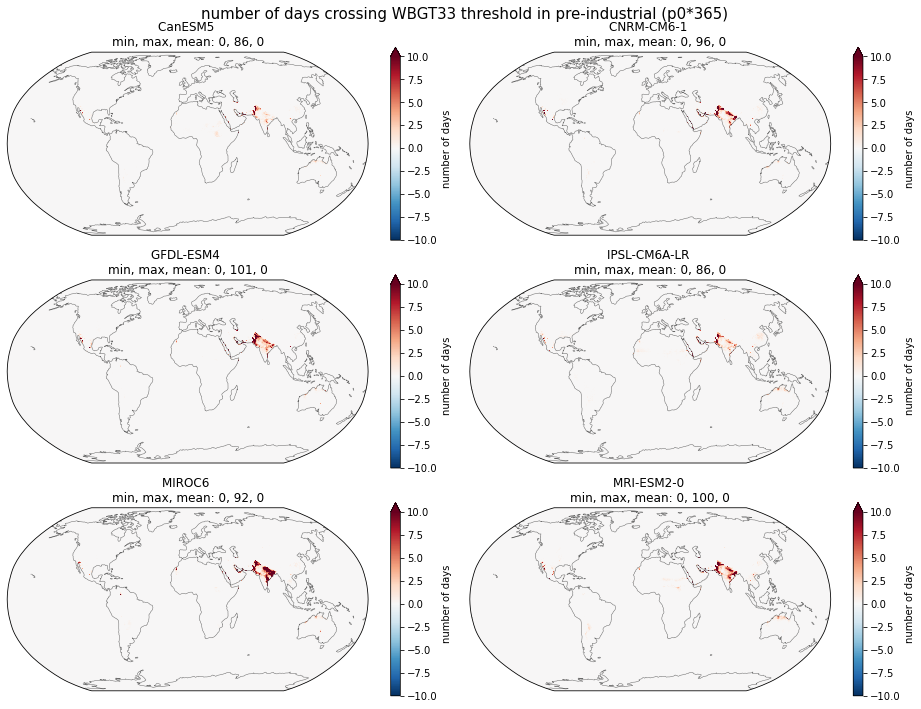

In [7]:
proj = ccrs.Robinson()
landmask = get_mask()
crs = ccrs.PlateCarree()
vmax = 10
levels = np.linspace(-vmax,vmax,num=20)

fig, axes = plt.subplots(3,2,figsize=(13,10), subplot_kw={'projection': proj})
axes = axes.flatten() 

for GCM, ax in zip(GCMs, axes):
    data_plot = (da_p0_WBGT.sel(model=GCM) *365).rename('number of days') #*landmask
    data_plot.plot(ax=ax, cmap = 'RdBu_r', vmax=vmax, vmin=-vmax, transform=crs )  #extend='max'
    ax.set_title(f'{GCM} \nmin, max, mean: {data_plot.min():.0f}, {data_plot.max():.0f}, {data_plot.mean():.0f}')
    ax.coastlines(color='dimgray', linewidth=0.5)
    
fig.suptitle(f'number of days crossing {metric_script} threshold in pre-industrial (p0*365)', size=15);
fig.tight_layout()

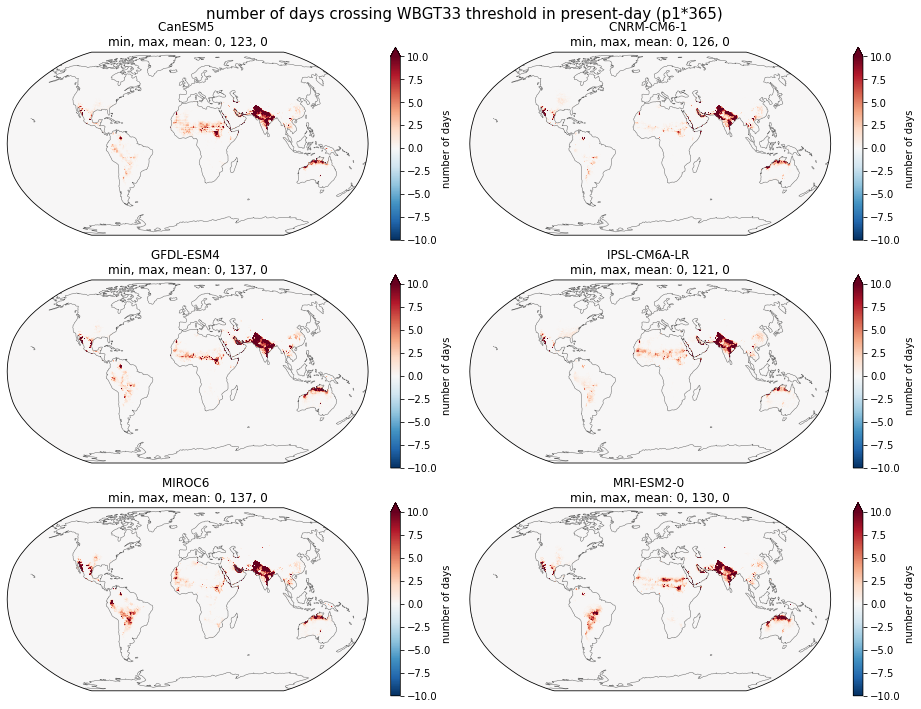

In [8]:
# p1

proj = ccrs.Robinson()
landmask = get_mask()
crs = ccrs.PlateCarree()
vmax = 10
levels = np.linspace(-vmax,vmax,num=20)

fig, axes = plt.subplots(3,2,figsize=(13,10), subplot_kw={'projection': proj})
axes = axes.flatten() 

for GCM, ax in zip(GCMs, axes):
    data_plot = (da_p1_WBGT.sel(model=GCM) *365).rename('number of days') #*landmask
    data_plot.plot(ax=ax, cmap = 'RdBu_r', vmax=vmax, vmin=-vmax, transform=crs )  #extend='max'
    ax.set_title(f'{GCM} \nmin, max, mean: {data_plot.min():.0f}, {data_plot.max():.0f}, {data_plot.mean():.0f}')
    ax.coastlines(color='dimgray', linewidth=0.5)

fig.suptitle(f'number of days crossing {metric_script} threshold in present-day (p1*365)', size=15);
fig.tight_layout()

In [9]:
da_nAHD_WBGT = open_all_nAHD(GCMs,  metric=metric_script, outdirname=dirname)

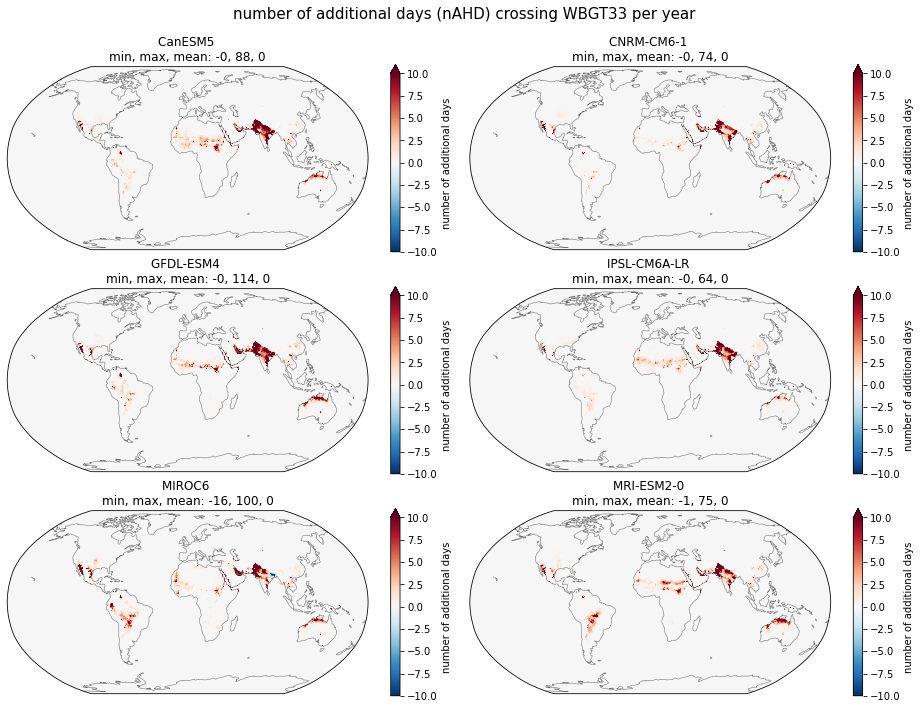

In [10]:
proj = ccrs.Robinson()
landmask = get_mask()
crs = ccrs.PlateCarree()
vmax = 10
levels = np.linspace(-vmax,vmax,num=20)

fig, axes = plt.subplots(3,2,figsize=(13,10), subplot_kw={'projection': proj})
axes = axes.flatten() 

for GCM, ax in zip(GCMs, axes):
    data_plot = da_nAHD_WBGT.sel(model=GCM) #*landmask
    data_plot.plot(ax=ax, cmap = 'RdBu_r', vmax=vmax, vmin=-vmax, transform=crs, extend='max') 
    ax.set_title(f'{GCM} \nmin, max, mean: {data_plot.min():.0f}, {data_plot.max():.0f}, {data_plot.mean():.0f}')
    ax.coastlines(color='dimgray', linewidth=0.5)
    #ax.add_feature(cfeature.BORDERS, facecolor="none", edgecolor='dimgray', linewidth=0.5 )
    
fig.suptitle(f'number of additional days (nAHD) crossing {metric_script} per year\n', size=15);
fig.tight_layout()

places where in PI it is impossible and no longer impossible in present:

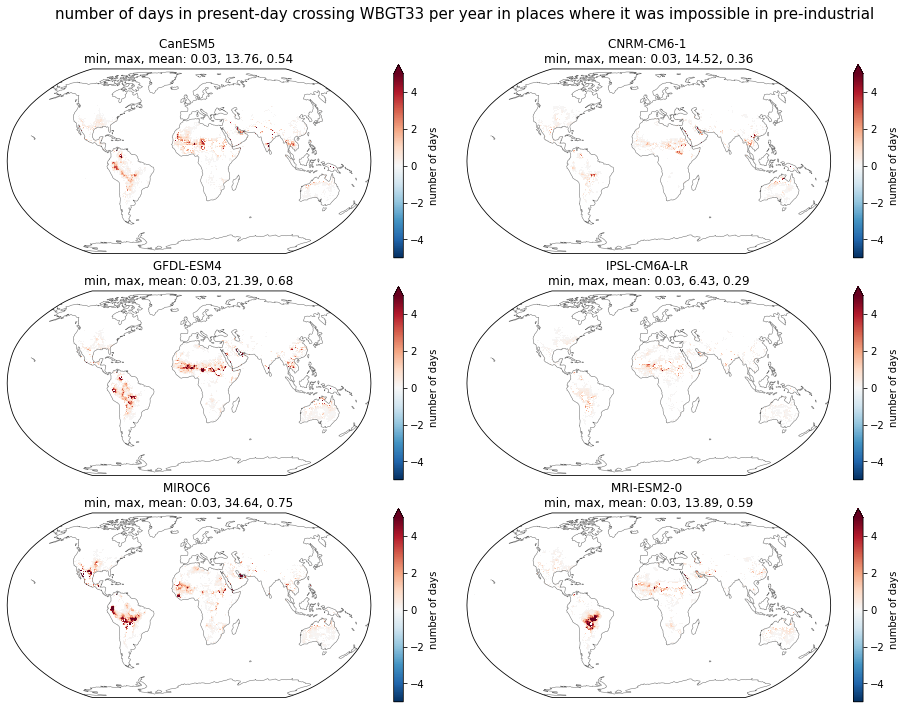

In [11]:
proj = ccrs.Robinson()
landmask = get_mask()
crs = ccrs.PlateCarree()
vmax = 5
levels = np.linspace(-vmax,vmax,num=20)

fig, axes = plt.subplots(3,2,figsize=(13,10), subplot_kw={'projection': proj})
axes = axes.flatten() 

for GCM, ax in zip(GCMs, axes):
    data_plot = (da_p1_WBGT.where(da_p0_WBGT == 0).where(da_p1_WBGT !=0 ).sel(model=GCM) *365).rename('number of days') #*landmask
    data_plot.plot(ax=ax, cmap = 'RdBu_r', vmax=vmax, vmin=-vmax, transform=crs, extend='max') 
    ax.set_title(f'{GCM} \nmin, max, mean: {data_plot.min():.2f}, {data_plot.max():.2f}, {data_plot.mean():.2f}')
    ax.coastlines(color='dimgray', linewidth=0.5)
    #ax.add_feature(cfeature.BORDERS, facecolor="none", edgecolor='dimgray', linewidth=0.5 )
    
fig.suptitle(f'number of days in present-day crossing {metric_script} per year in places where it was impossible in pre-industrial\n', size=15);
fig.tight_layout()

## combine with demographics

In [12]:
d_countries = preprocess_all_country_population_data()
gs_population_global = get_gridscale_population_global( 
    d_countries,
    startyear=2022,
    endyear=None,
    save=False # change where this gets saved !!!! now its in package folder
)

interpolating cohort sizes per country
after interpolation and mean-preserving correction there are some neg numbers in 10, Azerbaijan, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 98, Libya, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 136, Papua New Guinea, setting them to zero
Aruba small, population not calculated
Antigua and Barbuda small, population not calculated
Bahrain small, population not calculated
Barbados small, population not calculated
Federated States of Micronesia small, population not calculated
Grenada small, population not calculated
Guam small, population not calculated
Saint Lucia small, population not calculated
Macao small, population not calculated
Maldives small, population not calculated
Malta small, population not calculated
Singapore small, population not calculated
Tonga small, population not calculated
calculating gridscale population per cou

In [13]:
#nAHD : number of people and proportion of age group living through at least x additional days 

da_n_people_ndays, da_prop_people_ndays = calc_number_proportion_people_atleastxdays_10yr(gs_population_global, 
                                                                                          GCMs, 
                                                                                          da_nAHD_WBGT,  
                                                                                          x_hot_days = [1,5,10,20,50])


da_n_people_1y, da_prop_people_1y = calc_number_proportion_people_atleastxdays_1yr(gs_population_global, 
                                                                                     GCMs, 
                                                                                     da_nAHD_WBGT, 
                                                                                     x_hot_days = [1, 5, 10, 20, 50], 
                                                                                     ages_values=range(0,100),
                                                                                     grouped = False,
                                                                                     size_win = None
                                                                                    )


In [14]:
#nAHD : average per capita additional days and people x additional days 


# TODO: look also at baseline in p1 !! 

da_nAHD_percapita_peopledays_18y = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                           GCMs, 
                                           da_nAHD_WBGT,
                                           x_hot_days = [1, 5, 10, 20, 50], 
                                           ages_values=range(0,100),
                                           grouped = True,
                                           size_win = 18
                                           )

da_nAHD_percapita_peopledays_10y = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                           GCMs, 
                                           da_nAHD_WBGT,
                                           x_hot_days = [1, 5, 10, 20, 50], 
                                           ages_values=range(0,100),
                                           grouped = True,
                                           size_win = 10
                                           )

da_nAHD_percapita_peopledays_1y = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                           GCMs, 
                                           da_nAHD_WBGT,
                                           x_hot_days = [1, 5, 10, 20, 50], 
                                           ages_values=range(0,100),
                                           grouped = False,
                                           size_win = None
                                           )

In [15]:
# absolute number of days crossing threshold (not just additional)

da_totaldays_percapita_peopledays_18y = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                           GCMs, 
                                           da_p1_WBGT * 365,
                                           x_hot_days = [1, 5, 10, 20, 50], 
                                           ages_values=range(0,100),
                                           grouped = True,
                                           size_win = 18
                                           )

da_totaldays_percapita_peopledays_10y = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                           GCMs, 
                                           da_p1_WBGT * 365,
                                           x_hot_days = [1, 5, 10, 20, 50], 
                                           ages_values=range(0,100),
                                           grouped = True,
                                           size_win = 10
                                           )
da_totaldays_percapita_peopledays_1y = calc_percapita_hotdays_peopledays_1yr(gs_population_global, 
                                           GCMs, 
                                           da_p1_WBGT * 365,
                                           x_hot_days = [1, 5, 10, 20, 50], 
                                           ages_values=range(0,100),
                                           grouped = False,
                                           size_win = None
                                           )

da_n_people_1y_totaldays, da_prop_people_1y_totaldays = calc_number_proportion_people_atleastxdays_1yr(gs_population_global, 
                                                                                     GCMs, 
                                                                                     da_p1_WBGT * 365, 
                                                                                     x_hot_days = [1, 5, 10, 20, 50], 
                                                                                     ages_values=range(0,100),
                                                                                     grouped = False,
                                                                                     size_win = None
                                                                                    )

## Do some plots

### 1. Number of people and proportion of age group living through x additional days crossing WBGT33

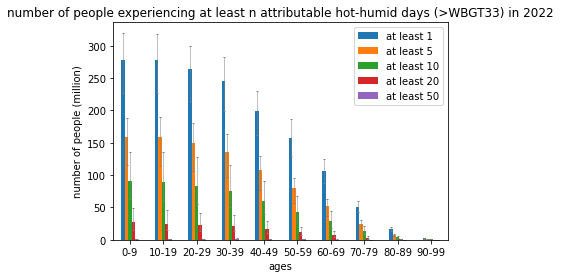

In [16]:
fig, ax = plt.subplots()
plot_barplot_n_prop_people_atleastx_modelmean(da_n_people_ndays, unit=1e6, year=2022, ax=ax, proportion=False)
plt.legend(labels = [f'at least {x}' for x in  [1, 5, 10, 20, 50]])
ax.set_title(f'number of people experiencing at least n attributable hot-humid days (>{metric_script}) in 2022');

#plt.savefig(os.path.join(figdir,'n_atleastx_2022_10yr.png'),dpi=300)

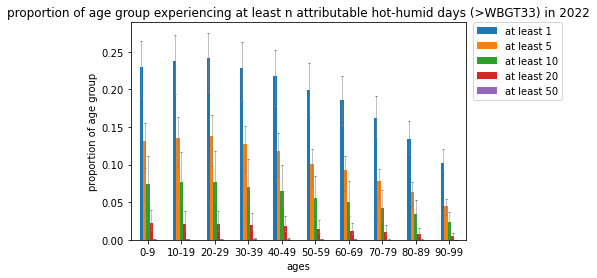

In [17]:
fig, ax = plt.subplots()
plot_barplot_n_prop_people_atleastx_modelmean(da_prop_people_ndays, unit=1, year=2022, ax=ax, proportion=True)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, labels = [f'at least {x}' for x in  [1, 5, 10, 20, 50]])
ax.set_title(f'proportion of age group experiencing at least n attributable hot-humid days (>{metric_script}) in 2022');

#plt.savefig(os.path.join(figdir,'prop_atleastx_2022_10yr.png'),dpi=300)

### 2. Per capita additional days per age group

In [18]:
df_percapitadays_10y = da_nAHD_percapita_peopledays_10y.sel(features='per_capita_days').to_pandas().T
#df_percapitadays_10y

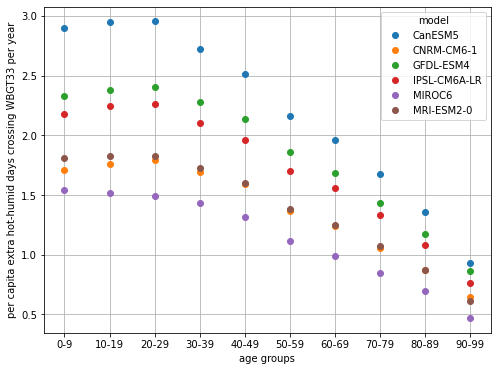

In [19]:
fig, ax = plt.subplots(figsize=(8,6))
df_plot = df_percapitadays_10y
df_plot.plot(marker='o',linestyle='None', ax=ax)
plt.ylabel(f'per capita extra hot-humid days crossing {metric_script} per year')
plt.xlabel('age groups')
plt.xticks(df_plot.index);
plt.grid()
ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+9}' for x in df_plot.index], rotation='horizontal');


In [20]:
df_percapitadays_18y = da_nAHD_percapita_peopledays_18y.sel(features='per_capita_days').to_pandas().T
df_percapitadays_18y

model,CanESM5,CNRM-CM6-1,GFDL-ESM4,IPSL-CM6A-LR,MIROC6,MRI-ESM2-0
age_ranges,,,,,,
0,2.916778,1.730965,2.345792,2.201778,1.532690,1.815203
18,2.887777,1.760224,2.364095,2.217467,1.476764,1.796860
36,2.495177,1.574275,2.121199,1.947126,1.308269,1.591384
54,2.006892,1.267528,1.723721,1.588413,1.020594,1.282555
72,1.551093,0.977584,1.329972,1.232562,0.788320,0.993753
90,0.934203,0.642901,0.862177,0.763624,0.470315,0.610827


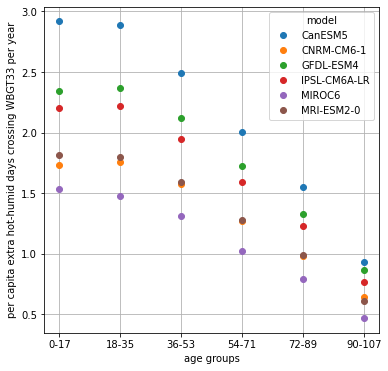

In [21]:
fig, ax = plt.subplots(figsize=(6,6))
df_plot = df_percapitadays_18y
df_plot.plot(marker='o',linestyle='None', ax=ax)
plt.ylabel(f'per capita extra hot-humid days crossing {metric_script} per year')
plt.xlabel('age groups')
plt.xticks(df_plot.index);
plt.grid()
ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+17}' for x in df_plot.index], rotation='horizontal');

#plt.savefig(os.path.join(figdir,'percapita_hotdays_18y_TX99.png'), dpi=300, transparent=False)

In [22]:
df_percapitadays_18y.median(axis=1)

age_ranges
0     2.008491
18    2.007163
36    1.769255
54    1.435484
72    1.113157
90    0.703263
dtype: float64

In [23]:
df_percapitadays_18y.mean(axis=1)

age_ranges
0     2.090534
18    2.083864
36    1.839572
54    1.481617
72    1.145547
90    0.714008
dtype: float64

### 3. summary results children v. adults 

TODO:
- make this a fxn and check it !
- check i am not only considering places where increase 

In [24]:
def calc_weighted_average(df_values, df_weights, start, stop):
    
    ''' stop is excluded'''
    print(f'note: loc {stop} is excluded')
    
    try:
        weighted_avg = df_values.iloc[start:stop].multiply(df_weights[start:stop], axis = 0).sum(axis=0).divide(df_weights[start:stop].sum(), axis=0)
    except:
        weighted_avg = df_values.iloc[start:stop].multiply(df_weights[start:stop], axis = 0).sum(axis=0) / df_weights[start:stop].sum(axis=0)

        
    return weighted_avg
    
    # check this !!!! 
    

In [25]:
def format_large_numbers(x):
    try:
        x = float(x)
        if abs(x) >= 1e9:
            return f'{x/1e9:.1f}B'
        if abs(x) >= 1e6:
            return f'{x/1e6:.1f}M'
        if abs(x) >= 1e3:
            return f'{x/1e3:.1f}K'
        if abs(x) <= 1e3:
            return f'{x:.1f}'
        return str(x)
    except ValueError:
        return x


In [26]:
# number of children versus number of adults living in places where increase 
ch_end = 18
ad_end = 58 

df = da_n_people_1y.sel(features='n_whrincr').to_pandas().T

children_whr_increase = df.iloc[0:ch_end].sum(axis=0)
adults_whr_increase = df.iloc[40:ad_end].sum(axis=0)

In [27]:
df = da_nAHD_percapita_peopledays_1y.sel(features='people_days').to_pandas().T

children_peopledays = df.iloc[0:ch_end].sum(axis=0) 
adults_peopledays = df.iloc[ad_end-18:ad_end].sum(axis=0)

In [28]:
df_values = da_nAHD_percapita_peopledays_1y.sel(features='per_capita_days').to_pandas().T
df_npeople = da_nAHD_percapita_peopledays_1y.sel(features='n_people').to_pandas().T

children_percapita =  calc_weighted_average(df_values, df_npeople, 0, ch_end)
adults_percapita = calc_weighted_average(df_values, df_npeople, ad_end-18, ad_end)

# note! check i am not only considering places where increase 

note: loc 18 is excluded
note: loc 58 is excluded


In [29]:
df_summary = pd.concat([children_whr_increase,
           adults_whr_increase,
          children_peopledays,
          adults_peopledays,
          children_percapita,
          adults_percapita], axis=1,
         keys= ['children_whr_increase',
           'adults_whr_increase',
          'children_peopledays',
          'adults_peopledays',
          'children_percapita',
          'adults_percapita'])

In [30]:

df_summary.applymap(format_large_numbers)

# this gives the same as above, but different to my old function - check why !! 
# if you do 0-18 included and 40-58 included number of people is the same but people x days and per capita days are different
# see attr-hw-isimip3b-TX99-exposure-dev0 & understand why 

,children_whr_increase,adults_whr_increase,children_peopledays,adults_peopledays,children_percapita,adults_percapita
model,,,,,,
CanESM5,1.0B,728.2M,6.3B,3.7B,2.9,2.4
CNRM-CM6-1,859.5M,625.8M,3.7B,2.3B,1.7,1.5
GFDL-ESM4,966.8M,691.9M,5.0B,3.2B,2.3,2.0
IPSL-CM6A-LR,1.0B,736.4M,4.7B,2.9B,2.2,1.9
MIROC6,815.1M,589.9M,3.3B,1.9B,1.5,1.2
MRI-ESM2-0,882.2M,636.9M,3.9B,2.4B,1.8,1.5


In [31]:
pd.DataFrame(df_summary.median(axis=0), columns=['median']).applymap(format_large_numbers)

,median
children_whr_increase,924.5M
adults_whr_increase,664.4M
children_peopledays,4.3B
adults_peopledays,2.6B
children_percapita,2.0
adults_percapita,1.7


### 4. total days, not only attributable, in present-day

In [32]:
df_percapitadays_10y_tot = da_totaldays_percapita_peopledays_10y.sel(features='per_capita_days').to_pandas().T
#df_percapitadays_10y

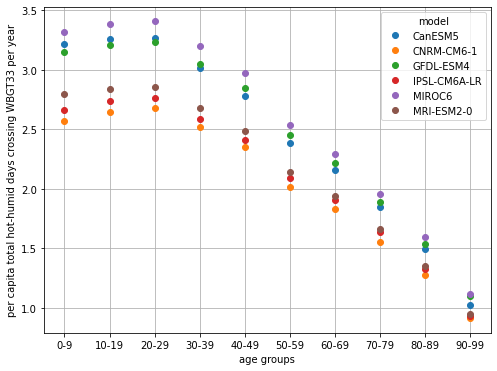

In [33]:
fig, ax = plt.subplots(figsize=(8,6))
df_plot = df_percapitadays_10y_tot
df_plot.plot(marker='o',linestyle='None', ax=ax)
plt.ylabel(f'per capita total hot-humid days crossing {metric_script} per year')
plt.xlabel('age groups')
plt.xticks(df_plot.index);
plt.grid()
ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+9}' for x in df_plot.index], rotation='horizontal');


In [34]:
df_percapitadays_18y_tot = da_totaldays_percapita_peopledays_18y.sel(features='per_capita_days').to_pandas().T
df_percapitadays_18y_tot

model,CanESM5,CNRM-CM6-1,GFDL-ESM4,IPSL-CM6A-LR,MIROC6,MRI-ESM2-0
age_ranges,,,,,,
0,3.233517,2.596775,3.169761,2.690858,3.343194,2.813842
18,3.194584,2.628198,3.178163,2.709206,3.346348,2.804567
36,2.762965,2.330216,2.825315,2.389011,2.949360,2.469608
54,2.212521,1.869063,2.270969,1.947790,2.346154,1.986645
72,1.707164,1.438756,1.746273,1.510880,1.807938,1.535383
90,1.021548,0.912750,1.100808,0.929358,1.114914,0.943835


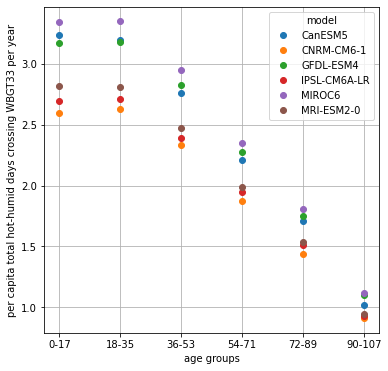

In [35]:
fig, ax = plt.subplots(figsize=(6,6))
df_plot = df_percapitadays_18y_tot
df_plot.plot(marker='o',linestyle='None', ax=ax)
plt.ylabel(f'per capita total hot-humid days crossing {metric_script} per year')
plt.xlabel('age groups')
plt.xticks(df_plot.index);
plt.grid()
ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+17}' for x in df_plot.index], rotation='horizontal');

#plt.savefig(os.path.join(figdir,'percapita_hotdays_18y_TX99.png'), dpi=300, transparent=False)

In [36]:
df_percapitadays_18y_tot.median(axis=1)

age_ranges
0     2.991802
18    2.991365
36    2.616287
54    2.099583
72    1.621274
90    0.982691
dtype: float64

In [37]:
df_percapitadays_18y_tot.mean(axis=1)

age_ranges
0     2.974658
18    2.976844
36    2.621079
54    2.105524
72    1.624399
90    1.003869
dtype: float64

### 5. summary results total days

In [38]:
da_n_people_1y.isel(model=0).to_pandas() # nAHD

features,n_atleast_1,n_atleast_5,n_atleast_10,n_atleast_20,n_atleast_50,n_whrincr
age_ranges,,,,,,
0,2.995346e+07,1.873966e+07,1.349121e+07,4.874167e+06,183033.611560,5.688678e+07
1,2.996726e+07,1.876159e+07,1.350574e+07,4.869832e+06,182362.593420,5.698265e+07
2,2.998107e+07,1.878352e+07,1.352028e+07,4.865498e+06,181691.575280,5.707852e+07
3,2.999488e+07,1.880545e+07,1.353481e+07,4.861163e+06,181020.557141,5.717439e+07
4,3.000868e+07,1.882738e+07,1.354934e+07,4.856829e+06,180349.539001,5.727026e+07
...,...,...,...,...,...,...
95,1.435602e+05,7.568190e+04,4.949837e+04,1.154653e+04,204.684493,4.593940e+05
96,1.026679e+05,5.382303e+04,3.486628e+04,7.965110e+03,131.264216,3.355910e+05
97,6.177563e+04,3.196416e+04,2.023419e+04,4.383687e+03,57.843938,2.117880e+05


In [39]:
da_n_people_1y_totaldays.isel(model=0).to_pandas() #totaldays

features,n_atleast_1,n_atleast_5,n_atleast_10,n_atleast_20,n_atleast_50,n_whrincr
age_ranges,,,,,,
0,3.046479e+07,1.910808e+07,1.396804e+07,6.028862e+06,596182.010175,5.696759e+07
1,3.048951e+07,1.913091e+07,1.398379e+07,6.027396e+06,595051.985104,5.706444e+07
2,3.051423e+07,1.915374e+07,1.399955e+07,6.025929e+06,593921.960033,5.716129e+07
3,3.053895e+07,1.917657e+07,1.401530e+07,6.024463e+06,592791.934962,5.725814e+07
4,3.056366e+07,1.919939e+07,1.403105e+07,6.022997e+06,591661.909891,5.735499e+07
...,...,...,...,...,...,...
95,1.515332e+05,7.734834e+04,5.181791e+04,1.648314e+04,677.332120,4.601627e+05
96,1.084651e+05,5.500276e+04,3.652549e+04,1.144993e+04,438.125020,3.361330e+05
97,6.539700e+04,3.265717e+04,2.123307e+04,6.416713e+03,198.917919,2.121033e+05


In [40]:
# number of children versus number of adults living in places where there are days crossing threshold 

# TODO: make this a fxn !!! 

ch_end = 18
ad_end = 58 

df = da_n_people_1y_totaldays.sel(features='n_whrincr').to_pandas().T # its not actually an increase here

children_whr_increase = df.iloc[0:ch_end].sum(axis=0)
adults_whr_increase = df.iloc[40:ad_end].sum(axis=0)

df = da_totaldays_percapita_peopledays_1y.sel(features='people_days').to_pandas().T

children_peopledays = df.iloc[0:ch_end].sum(axis=0) 
adults_peopledays = df.iloc[ad_end-18:ad_end].sum(axis=0)

df_values = da_totaldays_percapita_peopledays_1y.sel(features='per_capita_days').to_pandas().T
df_npeople = da_totaldays_percapita_peopledays_1y.sel(features='n_people').to_pandas().T

children_percapita =  calc_weighted_average(df_values, df_npeople, 0, ch_end)
adults_percapita = calc_weighted_average(df_values, df_npeople, ad_end-18, ad_end)

# note! check i am not only considering places where increase 

df_summary = pd.concat([children_whr_increase,
           adults_whr_increase,
          children_peopledays,
          adults_peopledays,
          children_percapita,
          adults_percapita], axis=1,
         keys= ['children_whr_increase',
           'adults_whr_increase',
          'children_peopledays',
          'adults_peopledays',
          'children_percapita',
          'adults_percapita'])

note: loc 18 is excluded
note: loc 58 is excluded


In [41]:
df_summary.applymap(format_large_numbers)

# different to my old function - check why !! 
# if you do 0-18 included and 40-58 included number of people is the same but people x days and per capita days are different
# see attr-hw-isimip3b-TX99-exposure-dev0 & understand why 

,children_whr_increase,adults_whr_increase,children_peopledays,adults_peopledays,children_percapita,adults_percapita
model,,,,,,
CanESM5,1.0B,729.7M,7.0B,4.1B,3.2,2.6
CNRM-CM6-1,869.8M,639.9M,5.6B,3.5B,2.6,2.2
GFDL-ESM4,967.6M,692.4M,6.8B,4.2B,3.2,2.7
IPSL-CM6A-LR,1.0B,738.8M,5.8B,3.6B,2.7,2.3
MIROC6,944.0M,674.4M,7.2B,4.4B,3.3,2.8
MRI-ESM2-0,906.1M,657.2M,6.1B,3.7B,2.8,2.4


In [42]:
pd.DataFrame(df_summary.median(axis=0), columns=['median']).applymap(format_large_numbers)

,median
children_whr_increase,955.8M
adults_whr_increase,683.4M
children_peopledays,6.4B
adults_peopledays,3.9B
children_percapita,3.0
adults_percapita,2.5
